In [ ]:
#!wget https://www.mediafire.com/file_premium/cok53fs0oxc0ymp/siamese.zip/file

In [ ]:
#!unzip file

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import random
import os
import torch
from collections import defaultdict

random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class ImagePairsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = self.load_data(f'{root_dir}/{csv_file}')
        self.root_dir = root_dir
        self.transform = transform
        self.d = self.load_dict()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        (img1_path, video1, interval1) = self.data[idx]
        remaining_keys = list(self.d[video1].keys())
        picked_key = random.choice(remaining_keys)
        img2_path = random.choice(self.d[video1][picked_key])
        similar = int(picked_key == interval1)

        # Load images
        img1 = Image.open(os.path.join(self.root_dir, img1_path)).convert('RGB')
        img2 = Image.open(os.path.join(self.root_dir, img2_path)).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, similar

    def load_data(self, csv_file):
        data = []
        with open(csv_file, 'r') as file:
            for line in file:
                filename, video, interval = line.strip().split(',')
                data.append((filename, video, interval))
        return data

    def load_dict(self):
        di = defaultdict(lambda: defaultdict(list))
        for data in self.data:
            path, video, interval = data
            di[video][interval].append(path)
        return di


# Example usage:
transform = transforms.Compose([
    transforms.Resize((640, 360)),
    transforms.ToTensor(),
])

dataset = ImagePairsDataset('tag.csv', 'siamese', transform=transform)

In [ ]:
batch_size=64
# Create DataLoader instances using the defined samplers
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
validation_dataset = ImagePairsDataset('validation.csv', 'siamese', transform=transform)
test_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# ones = 0
# for img1, img2, label in train_loader:
#   l = list(label)
#   ones += sum(l)
#   print(ones)
# print(ones/ len(train_loader))



In [ ]:
from torch import nn
from torch import flatten
from torch.functional import F


class SiameseNetwork(nn.Module):
    def __init__(self, resnet_model):
        super(SiameseNetwork, self).__init__()

        # Use the same ResNet model for both branches
        self.resnet_branch1 = resnet_model

        # Additional layers for prediction
        self.fc = nn.Linear(512, 400)
        self.fc2 = nn.Linear(400, 128)


    def forward_one_branch(self, x):
        x = self.resnet_branch1(x)
        x = F.leaky_relu(x)
        x = flatten(x, 1)
        x = self.fc(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        return x

    def forward(self, input1, input2):
        # Forward pass for each branch
        x1 = self.forward_one_branch(input1)
        x2 = self.forward_one_branch(input2)
        return x1,x2

In [ ]:
import torchvision.models as models

resnet_model = models.resnet18(pretrained=True)
resnet_model = torch.nn.Sequential(*list(resnet_model.children())[:-1])
for child in resnet_model.children():
    for param in child.parameters():
        param.requires_grad = True
resnet_model.train()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
siamese_net = SiameseNetwork(resnet_model)
siamese_net = siamese_net.to(device)


In [ ]:
import torch.nn.functional as F


class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()

    def forward(self, x1, x2, labels):
      cosine_similarity = F.cosine_similarity(x1, x2)
      loss = torch.mean(
          labels * torch.pow(1 - cosine_similarity, 2) +
           (1 - labels) * torch.pow(cosine_similarity * (cosine_similarity + 1), 2)
      )
      return loss


class ContrastiveEuclideanLoss(nn.Module):
    def __init__(self, margin):
        self.margin = margin
        super(ContrastiveEuclideanLoss, self).__init__()
    def forward(self, x1, x2, labels):
        euclidean_distance = F.pairwise_distance(x1, x2)
        loss = torch.mean(
            0.87 * (labels * euclidean_distance ** 2) +
            0.13 * ((1 - labels) * torch.clamp(self.margin - euclidean_distance, min=0.0) ** 2)
        )
        return loss


In [ ]:
print(len(train_loader))
print(len(test_loader))

143
59


In [ ]:
from torch.optim import SGD

min_loss = float('inf')
patience_counter = 0
patience = 20

# Use contrastive loss as the criterion
criterion = ContrastiveEuclideanLoss(1).to(device)

# Use Adam optimizer
optimizer = SGD(siamese_net.parameters(), lr=0.001)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    siamese_net.train()
    running_loss = 0
    for index, batch in enumerate(train_loader):
        img1, img2, labels = batch
        img1 = img1.to(device)
        img2 = img2.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        o1, o2 = siamese_net(img1, img2)

        # Compute contrastive loss
        loss = criterion(o1, o2, labels.float())
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.detach()

        print(f'Batch {index + 1} of {len(train_loader)}', running_loss / (index+1))
    # Validation
    siamese_net.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            img1, img2, labels = batch
            img1 = img1.to(device)
            img2 = img2.to(device)
            labels = labels.to(device)
            o1, o2 = siamese_net(img1, img2)
            val_loss += criterion(o1, o2, labels.float()).item()
    if val_loss < min_loss:
        min_loss = val_loss
        torch.save(siamese_net.state_dict(), f'drive/MyDrive/siamese_net10VDrop{val_loss}.pth')
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter == patience:
        break
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Val Loss: {val_loss/len(test_loader)}')

Streaming output truncated to the last 5000 lines.
Batch 40 of 143 tensor(0.0343, device='cuda:0')
Batch 41 of 143 tensor(0.0341, device='cuda:0')
Batch 42 of 143 tensor(0.0345, device='cuda:0')
Batch 43 of 143 tensor(0.0346, device='cuda:0')
Batch 44 of 143 tensor(0.0348, device='cuda:0')
Batch 45 of 143 tensor(0.0349, device='cuda:0')
Batch 46 of 143 tensor(0.0350, device='cuda:0')
Batch 47 of 143 tensor(0.0348, device='cuda:0')
Batch 48 of 143 tensor(0.0348, device='cuda:0')
Batch 49 of 143 tensor(0.0348, device='cuda:0')
Batch 50 of 143 tensor(0.0346, device='cuda:0')
Batch 51 of 143 tensor(0.0349, device='cuda:0')
Batch 52 of 143 tensor(0.0348, device='cuda:0')
Batch 53 of 143 tensor(0.0347, device='cuda:0')
Batch 54 of 143 tensor(0.0349, device='cuda:0')
Batch 55 of 143 tensor(0.0348, device='cuda:0')
Batch 56 of 143 tensor(0.0348, device='cuda:0')
Batch 57 of 143 tensor(0.0347, device='cuda:0')
Batch 58 of 143 tensor(0.0345, device='cuda:0')
Batch 59 of 143 tensor(0.0347, device

In [ ]:
val_model = SiameseNetwork(resnet_model).to(device)
val_model.eval()

SiameseNetwork(
  (resnet_branch1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

tensor([[-0.0599, -0.1252, -0.3082,  0.0222,  0.0045,  0.3401,  0.0365, -0.2409,
          0.5767,  0.1365, -0.3610,  0.1556, -0.1939, -0.1840, -0.4791,  0.1604,
          0.0515, -0.0063, -0.1351,  0.2144,  0.3013,  0.1500, -0.0375, -0.1685,
         -0.0984, -0.3577,  0.0047,  0.2897, -0.0537, -0.1387,  0.0262, -0.0859,
         -0.1439,  0.0799, -0.3391,  0.1252, -0.2625,  0.2261, -0.2109, -0.0351,
          0.4319,  0.1503,  0.0650,  0.0815,  0.0686,  0.1376,  0.1494, -0.1514,
          0.0366,  0.0198,  0.1561, -0.4460,  0.1041,  0.4291, -0.0925,  0.1990,
         -0.3486, -0.1812, -0.2457, -0.1855, -0.5742,  0.1539,  0.2265,  0.0029,
         -0.4469, -0.2510, -0.1520, -0.3768,  0.1792, -0.0115, -0.3364,  0.1470,
         -0.1514,  0.2452, -0.3515, -0.2577, -0.0901, -0.0694,  0.3243,  0.0385,
          0.0791, -0.2277,  0.0586, -0.0665, -0.3139,  0.0552,  0.4708,  0.2586,
          0.1697, -0.2316,  0.2884, -0.0903,  0.3924,  0.0485, -0.4029, -0.3787,
          0.0574,  0.4724,  

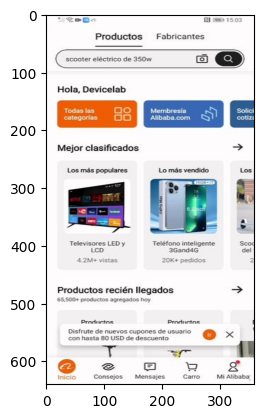

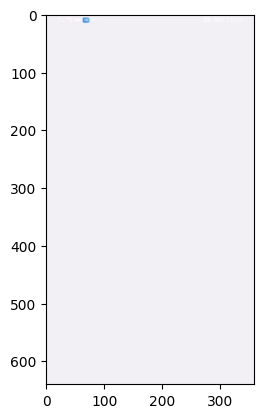

In [ ]:
import matplotlib.pyplot as plt

img1 = Image.open('siamese/3cd0a61fc5029e142806dc579a4288d1.jpg').convert('RGB')
img1 = transform(img1)
img1 = img1.unsqueeze(0)
img1 = img1.to(device)
img2 = Image.open('siamese/471e77f1ae8f0af148f3f50b8cb5b2bb.jpg').convert('RGB')
img2 = transform(img2)
img2 = img2.unsqueeze(0)
img2 = img2.to(device)
siamese_net.eval()
o1, o2 = val_model(img1, img2)
print(o1, o2)
print(F.cosine_similarity(o1, o2))


img1 = img1.cpu().squeeze().numpy().transpose(1,2,0)
img2 = img2.cpu().squeeze().numpy().transpose(1,2,0)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
